# Assignment1 : Denoising Using VAEs (PyTorch)
#### Student Name:

In this assignment, you will create a VAE Model to denoise the MNIST handwritten numbers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras

## Load the dataset

In [ ]:
from keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


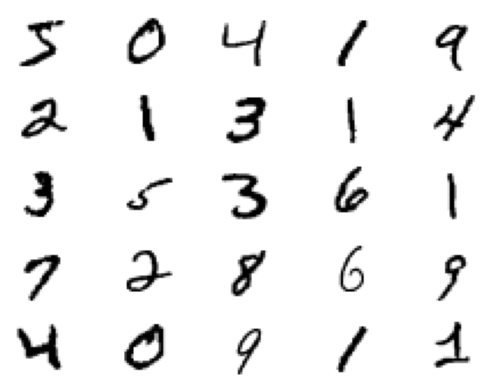

In [ ]:
from matplotlib import pyplot

for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(x_train[i], cmap='gray_r')
pyplot.show()

Normalize the values to 0-1 range

In [ ]:
test_images = x_test.astype('float32') / 255.0
test_images = np.reshape(test_images,(test_images.shape[0],28,28,1))

train_images = x_train.astype("float32") / 255.0
train_images = np.reshape(train_images, (train_images.shape[0],28,28,1))

## Generate Noisy images

In [ ]:
factor = 0.29
train_noisy_images = train_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = train_images.shape)
test_noisy_images = test_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = test_images.shape)

train_noisy_images = np.clip(train_noisy_images,0.,1.)
test_noisy_images = np.clip(test_noisy_images,0.,1.)

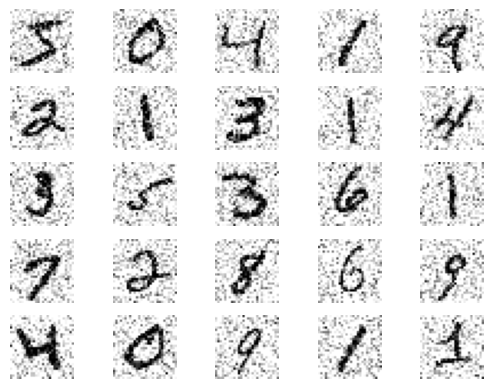

In [ ]:
from matplotlib import pyplot

for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(train_noisy_images[i], cmap='gray_r')
pyplot.show()

## Define and Train the Denoising VAE Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming you've already prepared your data as in your original code
# train_noisy_images and train_images are numpy arrays

# Convert numpy arrays to PyTorch tensors and permute to (batch_size, channels, height, width)
train_noisy_images = torch.FloatTensor(train_noisy_images).permute(0, 3, 1, 2)  # (batch_size, 1, 28, 28)
train_images = torch.FloatTensor(train_images).permute(0, 3, 1, 2)  # (batch_size, 1, 28, 28)

# Create dataset and dataloader
dataset = TensorDataset(train_noisy_images, train_images)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 64, 7, 7)  # Reshape to match the decoder's expected input
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantiate the model
latent_dim = 20
model = VAE(latent_dim)

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (noisy_data, data) in enumerate(dataloader):
        noisy_data, data = noisy_data.to(device), data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(noisy_data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}')

print("Training completed!")


Epoch 1, Loss: 166.0228
Epoch 2, Loss: 123.0715
Epoch 3, Loss: 117.1868
Epoch 4, Loss: 113.9213
Epoch 5, Loss: 111.9511
Epoch 6, Loss: 110.7773
Epoch 7, Loss: 109.9212
Epoch 8, Loss: 109.3218
Epoch 9, Loss: 108.8204
Epoch 10, Loss: 108.4323
Epoch 11, Loss: 108.0945
Epoch 12, Loss: 107.7438
Epoch 13, Loss: 107.4562
Epoch 14, Loss: 107.2364
Epoch 15, Loss: 106.9564
Epoch 16, Loss: 106.7278
Epoch 17, Loss: 106.5654
Epoch 18, Loss: 106.3875
Epoch 19, Loss: 106.2379
Epoch 20, Loss: 106.0451
Epoch 21, Loss: 105.9368
Epoch 22, Loss: 105.8039
Epoch 23, Loss: 105.6708
Epoch 24, Loss: 105.5582
Epoch 25, Loss: 105.4100
Epoch 26, Loss: 105.3143
Epoch 27, Loss: 105.2476
Epoch 28, Loss: 105.1371
Epoch 29, Loss: 105.0197
Epoch 30, Loss: 104.9015
Epoch 31, Loss: 104.8699
Epoch 32, Loss: 104.8116
Epoch 33, Loss: 104.7381
Epoch 34, Loss: 104.6261
Epoch 35, Loss: 104.5600
Epoch 36, Loss: 104.4768
Epoch 37, Loss: 104.3951
Epoch 38, Loss: 104.3529
Epoch 39, Loss: 104.2950
Epoch 40, Loss: 104.2351
Epoch 41,

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute reconstruction error (Mean Squared Error here)
def compute_reconstruction_error(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for noisy_data, data in dataloader:
            noisy_data, data = noisy_data.to(device), data.to(device)
            recon_data, mu, logvar = model(noisy_data)
            loss = nn.functional.mse_loss(recon_data, data, reduction='sum')
            total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

# Calculate error rate on training and test sets
train_loss = compute_reconstruction_error(model, dataloader, device)
print(f"Reconstruction Error on Training Set: {train_loss:.4f}")

Reconstruction Error on Training Set: 10.1688


## Evaluate the results
- What is the error rate on the train and test set?
- Visualoze 10 real images, with their cooresponding noisy versions, along the denoised version of the same image.

In [ ]:
# Prepare test set dataloader (similar to how we did for train)
test_noisy_images = torch.FloatTensor(test_noisy_images).permute(0, 3, 1, 2)
test_images = torch.FloatTensor(test_images).permute(0, 3, 1, 2)
test_dataset = TensorDataset(test_noisy_images, test_images)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

test_loss = compute_reconstruction_error(model, test_dataloader, device)
print(f"Reconstruction Error on Test Set: {test_loss:.4f}")

Reconstruction Error on Test Set: 10.3294


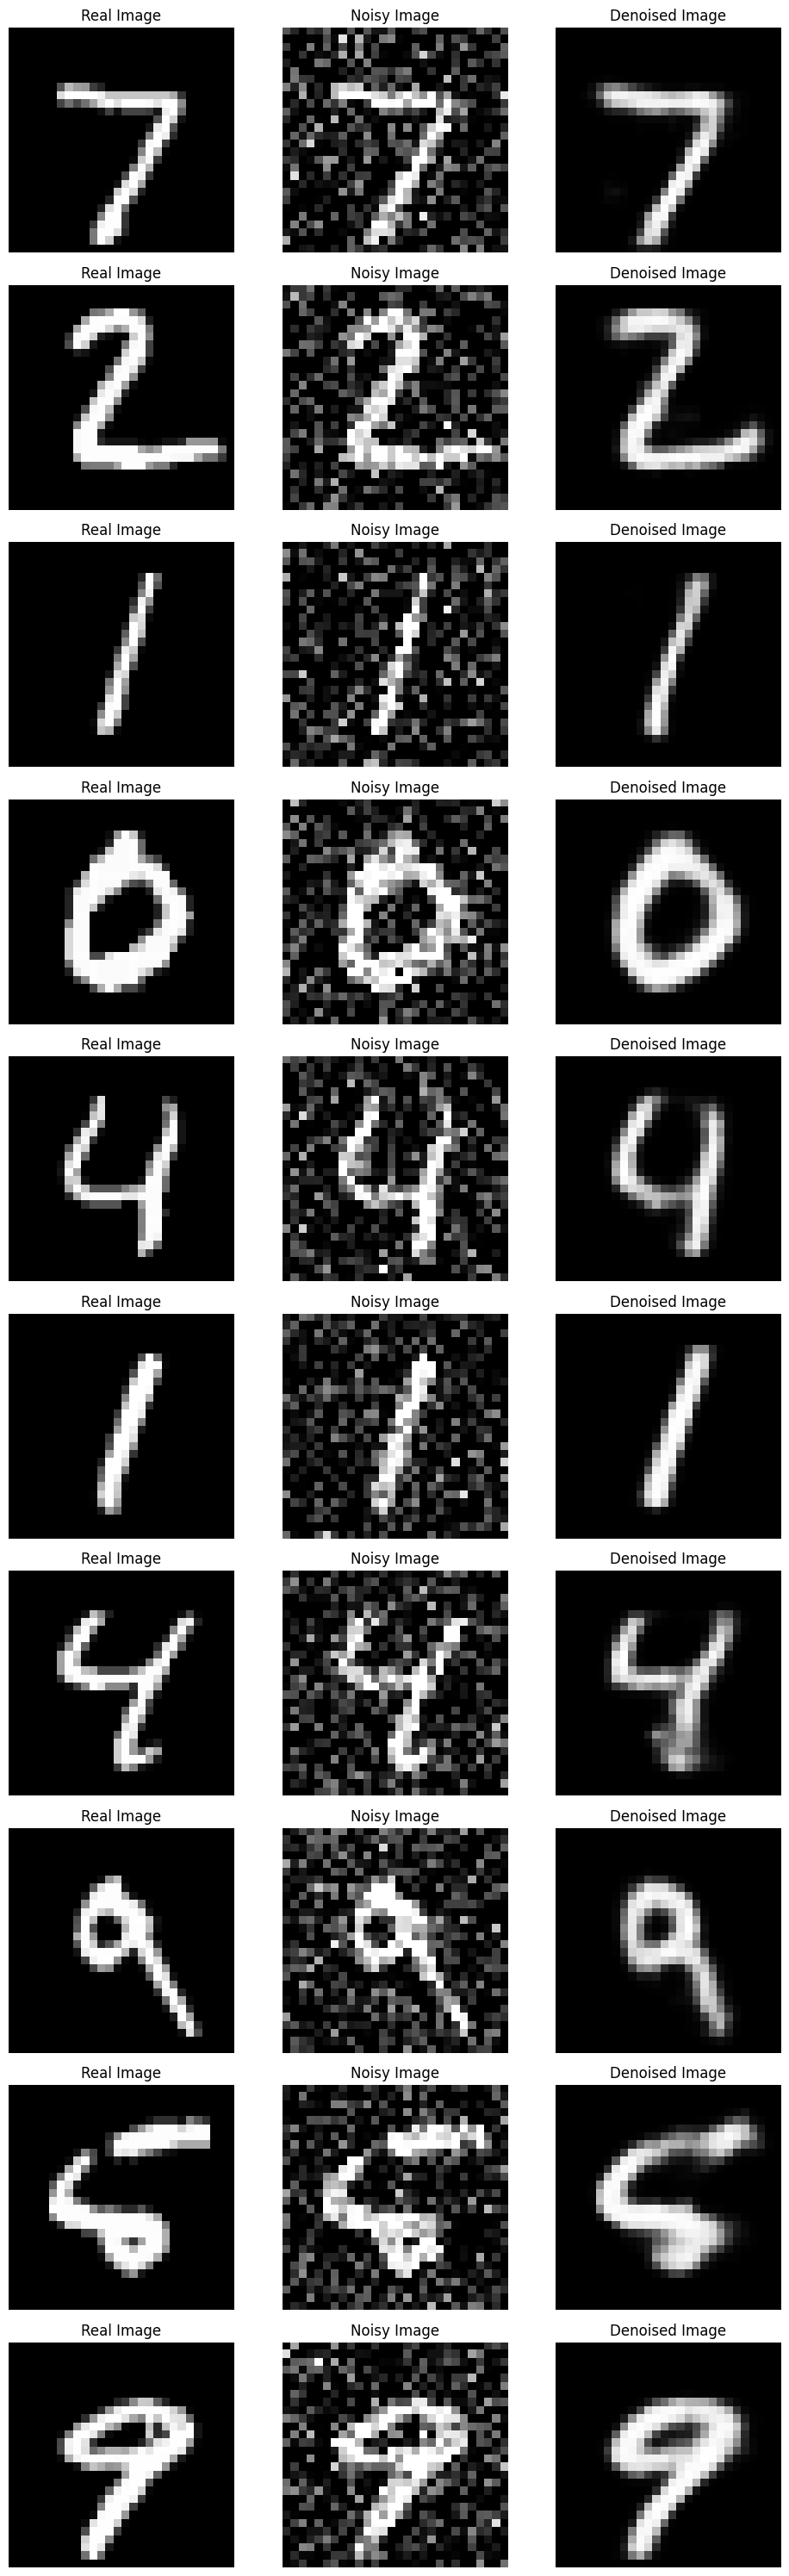

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize real, noisy, and denoised images
def visualize_results(model, test_noisy_images, test_images, device, num_images=10):
    model.eval()  # Set the model to evaluation mode
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    with torch.no_grad():  # Disable gradient calculation
        for i in range(num_images):
            noisy_img = test_noisy_images[i].unsqueeze(0).to(device)  # Add batch dimension (1, 1, 28, 28)
            real_img = test_images[i].cpu().numpy().squeeze()  # Original real image, shape (28, 28)

            denoised_img, _, _ = model(noisy_img)  # Get denoised output
            denoised_img = denoised_img.squeeze().cpu().numpy()  # Remove batch and channel dims, shape (28, 28)
            noisy_img = noisy_img.squeeze().cpu().numpy()  # Noisy image, shape (28, 28)

            # Plot the real, noisy, and denoised images
            axes[i, 0].imshow(real_img, cmap='gray')
            axes[i, 0].set_title("Real Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(noisy_img, cmap='gray')
            axes[i, 1].set_title("Noisy Image")
            axes[i, 1].axis('off')

            axes[i, 2].imshow(denoised_img, cmap='gray')
            axes[i, 2].set_title("Denoised Image")
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 10 images with real, noisy, and denoised versions
visualize_results(model, test_noisy_images, test_images, device, num_images=10)
